In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scvi

## Read 10x data

In [3]:
pbmc = sc.read_10x_mtx('../data/sc/pbmc3k/')
pbmc_10k = sc.read_10x_h5('../data/sc/10k_PBMC_3p_nextgem_Chromium_X_filtered_feature_bc_matrix.h5')
pbmc_10k.var_names_make_unique()
pbmc.layers['counts'] = pbmc.X.copy()
pbmc_10k.layers['counts'] = pbmc_10k.X.copy()


/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
pbmc

AnnData object with n_obs × n_vars = 2691 × 35635
    var: 'gene_ids'
    layers: 'counts'

## Set thresholds to remove low quality cells

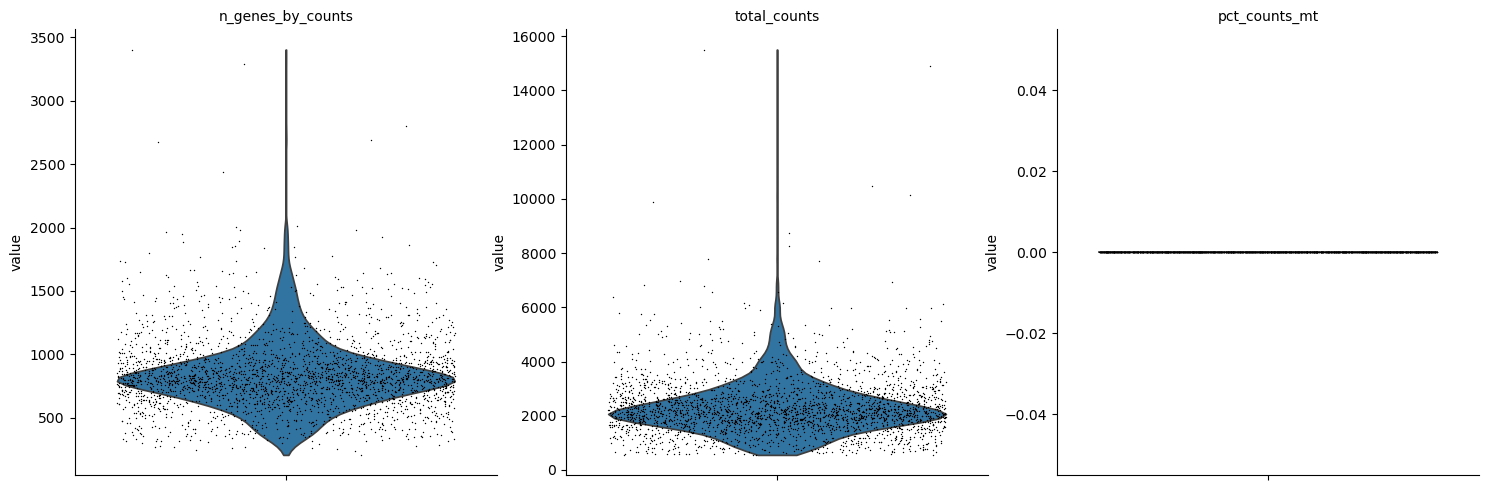

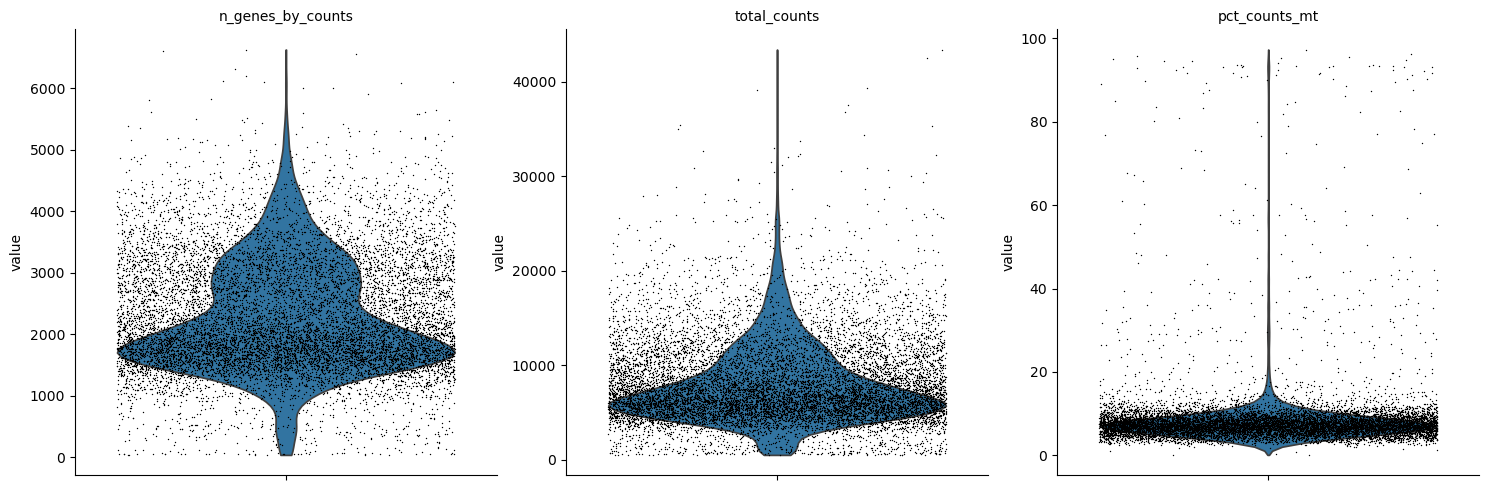

In [4]:
def qc(ad):
    ad.var['mt'] = ad.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    return ad
pbmc = qc(pbmc)
pbmc_10k = qc(pbmc_10k)

sc.pl.violin(
    pbmc,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.violin(
    pbmc_10k,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


{'n_genes_by_counts': [1558.9999999999982, 361.6], 'total_counts': [5078.199999999998, 735.0], 'pct_counts_mt': [0.0, 0.0]}
{'n_genes_by_counts': [4389.300000000001, 574.4000000000001], 'total_counts': [19670.0, 1351.8], 'pct_counts_mt': [27.673744392395022, 3.4399818420410155]}


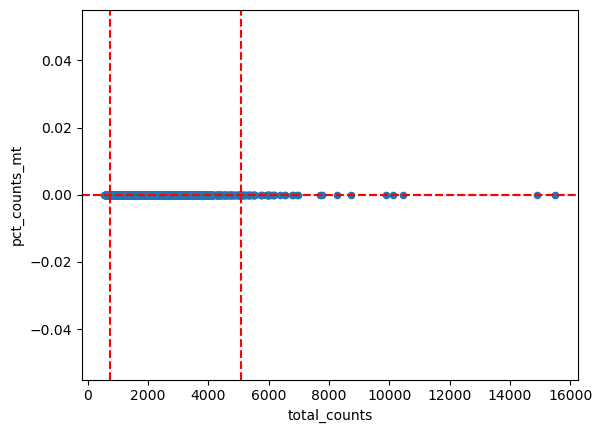

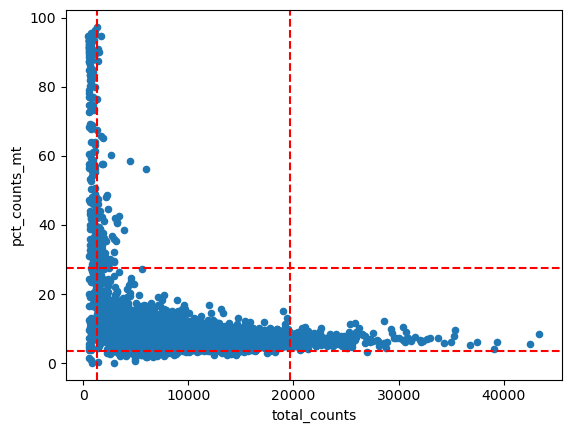

In [6]:
def dataset_qc_lim(ad,up=.98, down=.02):
    return {'n_genes_by_counts': [np.quantile(ad.obs.n_genes_by_counts.values, up),
                                  np.quantile(ad.obs.n_genes_by_counts.values, down)],
            'total_counts': [np.quantile(ad.obs.total_counts.values, up),
                             np.quantile(ad.obs.total_counts.values, down),],
            'pct_counts_mt': [np.quantile(ad.obs.pct_counts_mt.values, up),
                              np.quantile(ad.obs.pct_counts_mt.values, down)]
           }
    
pbmc_lim = dataset_qc_lim(pbmc)
pbmc_10k_lim = dataset_qc_lim(pbmc_10k)

print(pbmc_lim)
print(pbmc_10k_lim)
pbmc.obs.plot(kind='scatter', x="total_counts", y="pct_counts_mt")
plt.axvline(pbmc_lim['total_counts'][0], color='r', linestyle='--')
plt.axvline(pbmc_lim['total_counts'][1], color='r', linestyle='--')
plt.axhline(pbmc_lim['pct_counts_mt'][0], color='r', linestyle='--')
plt.axhline(pbmc_lim['pct_counts_mt'][1], color='r', linestyle='--')
plt.show()

pbmc_10k.obs.plot(kind='scatter', x="total_counts", y="pct_counts_mt")
plt.axvline(pbmc_10k_lim['total_counts'][0], color='r', linestyle='--')
plt.axvline(pbmc_10k_lim['total_counts'][1], color='r', linestyle='--')
plt.axhline(pbmc_10k_lim['pct_counts_mt'][0], color='r', linestyle='--')
plt.axhline(pbmc_10k_lim['pct_counts_mt'][1], color='r', linestyle='--')
plt.show()


### How many cells were removed ?

In [7]:
print(pbmc_10k.shape)
pbmc_10k = pbmc_10k[pbmc_10k.obs.pct_counts_mt.le(20) & pbmc_10k.obs.total_counts.le(30000)].copy()
sc.pp.filter_genes(pbmc_10k, min_cells=10)
print(pbmc_10k.shape)

print(pbmc.shape)
pbmc = pbmc[pbmc.obs.pct_counts_mt.le(10) & pbmc.obs.total_counts.le(8000)].copy()
sc.pp.filter_genes(pbmc, min_cells=10)
print(pbmc.shape)


(11996, 36601)
(11669, 18802)
(2691, 35635)
(2684, 11076)


## Doublet removal using AI

In [6]:
sc.pp.highly_variable_genes(pbmc, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

scvi.model.SCVI.setup_anndata(pbmc, layer='counts')
vae = scvi.model.SCVI(pbmc)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df_dbl = solo.predict()
df_dbl['prediction'] = solo.predict(soft = False)


/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.231. Signaling Trainer to stop.


/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


## Preprocessing 1 dataset

In [7]:
pbmc = sc.read_10x_mtx('../data/sc/pbmc3k/')
pbmc.layers['counts'] = pbmc.X.copy()
pbmc.obs['doublet'] = df_dbl.prediction.copy()

sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)
sc.pp.scale(pbmc)
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)

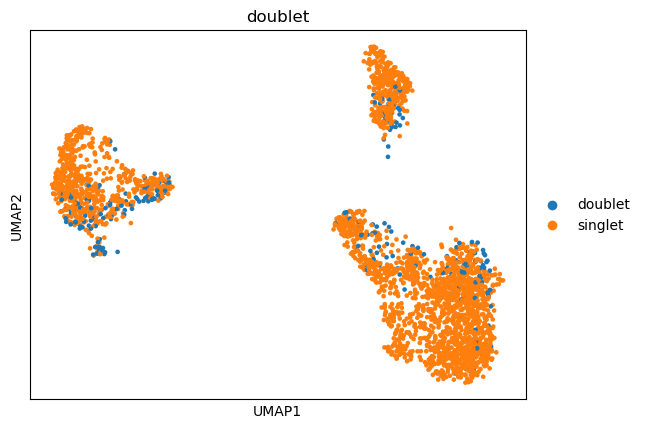

/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


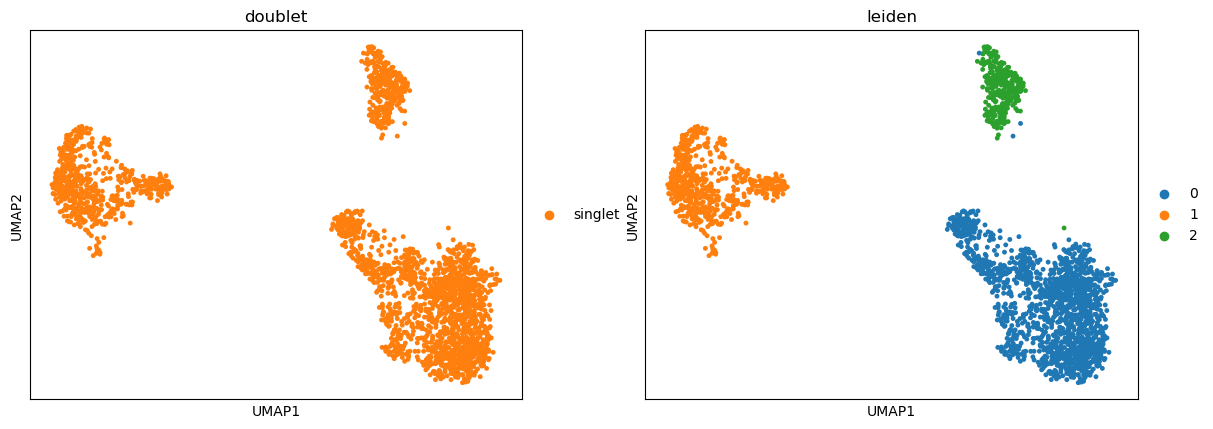

In [14]:
sc.tl.leiden(pbmc, resolution=.1)
sc.pl.umap(pbmc, color=['doublet'])
sc.pl.umap(pbmc[pbmc.obs.doublet.eq('singlet')], color=['doublet', 'leiden'])

/Users/gas361/anaconda3/envs/sc_2024/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


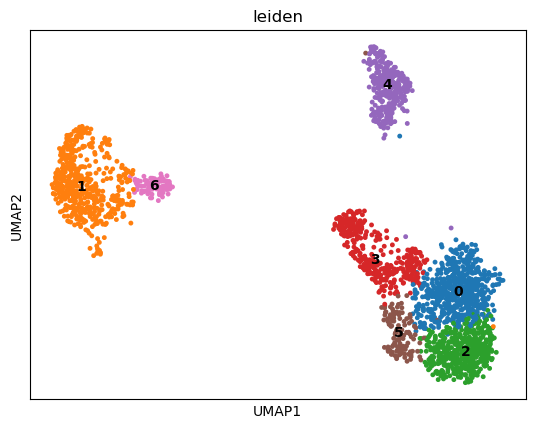

In [16]:
sc.tl.leiden(pbmc, resolution=.5)
sc.pl.umap(pbmc[pbmc.obs.doublet.eq('singlet')], color=['leiden'], legend_loc='on data')

## Find markers

In [17]:
pbmc.X = pbmc.layers['counts'].copy()
sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)

sc.tl.rank_genes_groups(pbmc, 'leiden')
markers = sc.get.rank_genes_groups_df(pbmc, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group  names     scores  logfoldchanges          pvals      pvals_adj
0          0   IL32  30.705652        2.588497  8.197293e-162  9.737018e-158
1          0    LTB  29.967266        2.372724  1.306459e-158  1.163892e-154
2          0   CD3D  26.876753        2.260720  4.180268e-130  1.862048e-126
3          0   LDHB  25.962894        1.895424  6.186693e-124  2.449587e-120
4          0   IL7R  22.010693        2.395099   9.951111e-88   1.418431e-84
...      ...    ...        ...             ...            ...            ...
214872     6   USB1   2.923782        1.367398   4.134122e-03   4.838076e-02
214873     6  ATP5I   2.923582        0.696295   4.104466e-03   4.808108e-02
214874     6  CSRP1   2.922232        1.349541   4.150395e-03   4.855526e-02
214875     6  PSEN1   2.920518        1.779400   4.180635e-03   4.887694e-02
214877     6  PFDN6   2.916692        1.192545   4.218127e-03   4.929910e-02

[4342 rows x 6 columns]

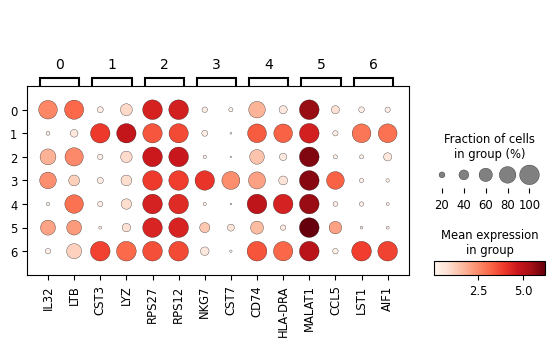

In [19]:
top_markers = []
for x in markers.groupby('group', observed=True ):
    top_markers +=x[1].iloc[0:1].names.tolist()

sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=2,  groupby="leiden", dendrogram = False)


<Axes: >

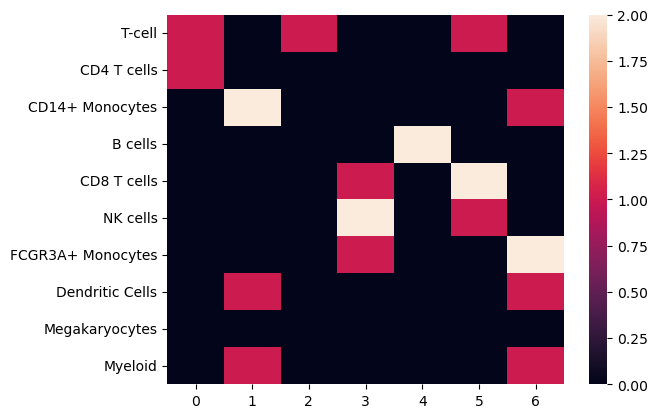

In [21]:
marker_genes = {
    'T-cell': ['CD3D'],
    'CD4 T cells': ['IL7R'],
    'CD14+ Monocytes': ['CD14', 'LYZ'],
    'B cells': ['MS4A1','CD79A'],
    'CD8 T cells': ['CD8A','CD8B'],
    'NK cells': ['GNLY', 'NKG7'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic Cells': ['FCER1A', 'CST3'],
    'Megakaryocytes': ['PPBP'],
    'Myeloid': ['CST3'],
}
marker_matches = sc.tl.marker_gene_overlap(pbmc, marker_genes)
sns.heatmap(marker_matches)

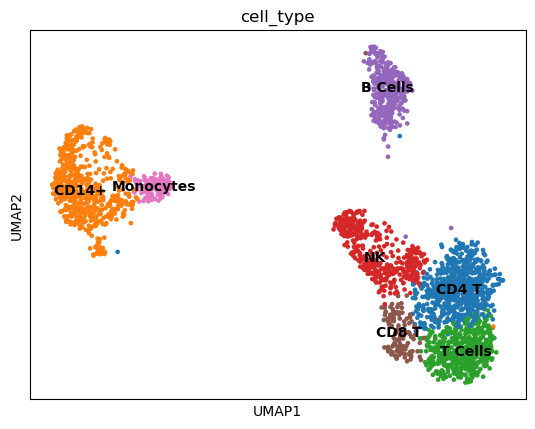

categories: CD4 T, CD14+ , T Cells, etc.
var_group_labels: T-cell, CD4 T cells, CD14+ Monocytes, etc.


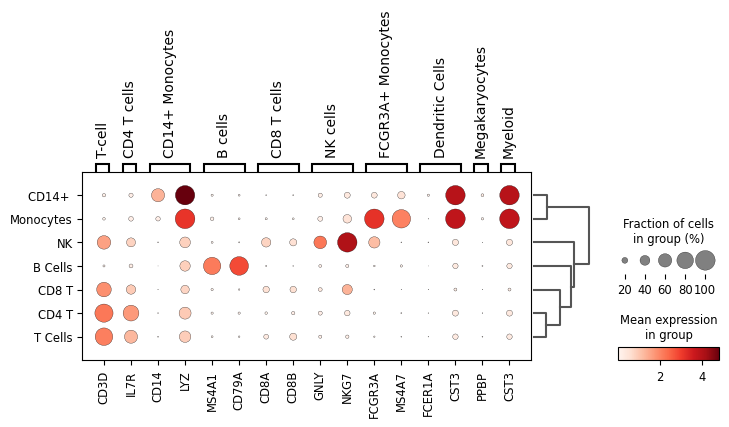

In [29]:
pbmc.obs['cell_type'] = pbmc.obs.leiden.map({'0':'CD4 T',
'1':'CD14+ ',
'2':'T Cells',
'3':'NK',
'4':'B Cells',
'5':'CD8 T',
'6':'Monocytes'})
sc.tl.dendrogram(pbmc, 'cell_type')
sc.pl.umap(pbmc, color=['cell_type'], legend_loc='on data')
sc.pl.dotplot(pbmc, marker_genes, 'cell_type', dendrogram=True)

## Dataset integration

In [53]:
pbmc.obs['batch'] = 'pbmc'
pbmc_10k.obs['batch'] = 'pbmc_10k'
combo = sc.concat([pbmc, pbmc_10k])

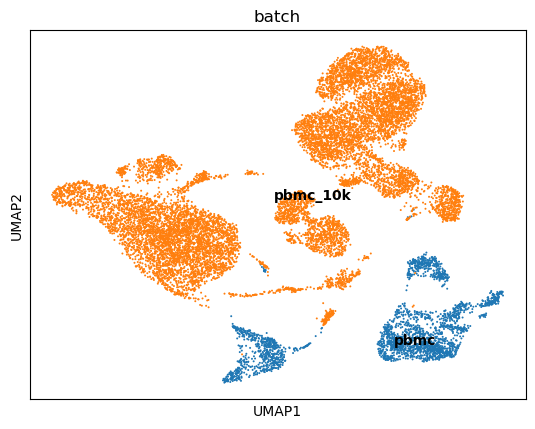

In [54]:
combo.X = combo.layers['counts'].copy()
sc.pp.normalize_total(combo, target_sum=1e4)
sc.pp.log1p(combo)
sc.pp.scale(combo)
sc.pp.pca(combo)
sc.pp.neighbors(combo)
sc.tl.umap(combo)
sc.pl.umap(combo, color='batch', legend_loc='on data')

In [8]:
# %pip install harmonypy

2024-11-07 08:38:51,371 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-07 08:38:52,740 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-07 08:38:52,781 - harmonypy - INFO - Iteration 1 of 20
2024-11-07 08:38:55,147 - harmonypy - INFO - Iteration 2 of 20
2024-11-07 08:38:57,448 - harmonypy - INFO - Iteration 3 of 20
2024-11-07 08:38:59,812 - harmonypy - INFO - Iteration 4 of 20
2024-11-07 08:39:02,061 - harmonypy - INFO - Converged after 4 iterations


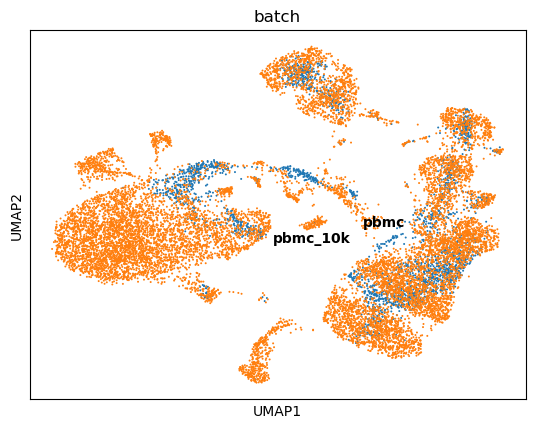

In [55]:
sce.pp.harmony_integrate(combo, 'batch', max_iter_harmony=20)
sc.pp.neighbors(combo, use_rep='X_pca_harmony')
sc.tl.umap(combo)
sc.pl.umap(combo, color='batch', legend_loc='on data')

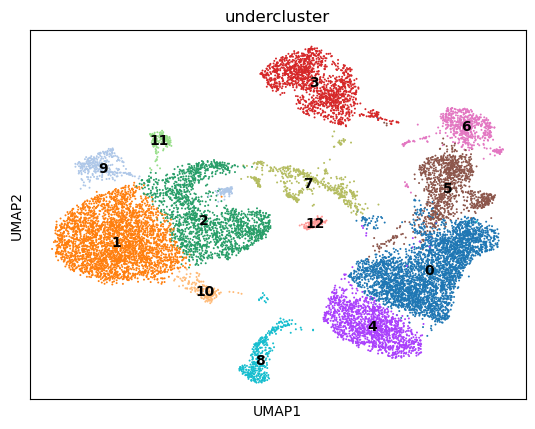

In [56]:
sc.tl.leiden(combo, resolution=.3, key_added='undercluster')
sc.pl.umap(combo, color='undercluster', legend_loc='on data')

In [57]:
combo.X = combo.layers['counts'].copy()
sc.pp.normalize_total(combo, target_sum=1e4)
sc.pp.log1p(combo)

sc.tl.rank_genes_groups(combo, 'undercluster')
markers = sc.get.rank_genes_groups_df(combo, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group   names     scores  logfoldchanges     pvals  pvals_adj
0          0     LTB  89.627480        2.852009  0.000000   0.000000
1          0   RPS27  88.950798        1.269845  0.000000   0.000000
2          0    RPS3  85.265938        1.373341  0.000000   0.000000
3          0    LDHB  82.994690        2.374811  0.000000   0.000000
4          0    CD3D  82.559525        2.801073  0.000000   0.000000
...      ...     ...        ...             ...       ...        ...
247573    12   BRPF1   2.377653        1.126269  0.019247   0.049879
247574    12  ZCCHC3   2.377131        0.884952  0.019270   0.049919
247575    12    TAF8   2.376954        0.814402  0.019281   0.049940
247576    12    PES1   2.376913        0.938580  0.019283   0.049940
247577    12  PPP6R3   2.376470        0.597184  0.019296   0.049966

[31387 rows x 6 columns]

<Axes: >

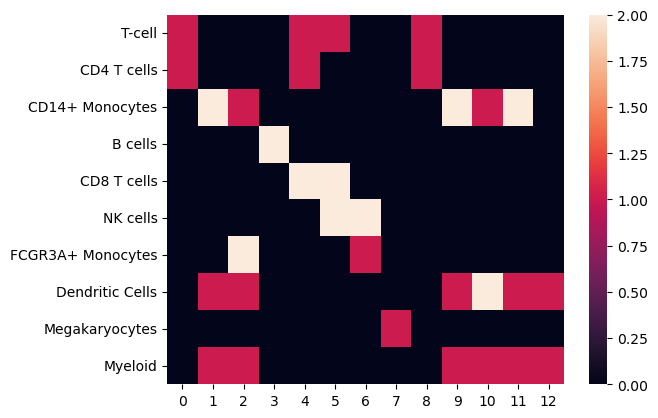

In [58]:
marker_genes = {
    'T-cell': ['CD3D'],
    'CD4 T cells': ['IL7R'],
    'CD14+ Monocytes': ['CD14', 'LYZ'],
    'B cells': ['MS4A1','CD79A'],
    'CD8 T cells': ['CD8A','CD8B'],
    'NK cells': ['GNLY', 'NKG7'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic Cells': ['FCER1A', 'CST3'],
    'Megakaryocytes': ['PPBP'],
    'Myeloid': ['CST3'],
}
marker_matches = sc.tl.marker_gene_overlap(combo, marker_genes)
sns.heatmap(marker_matches)

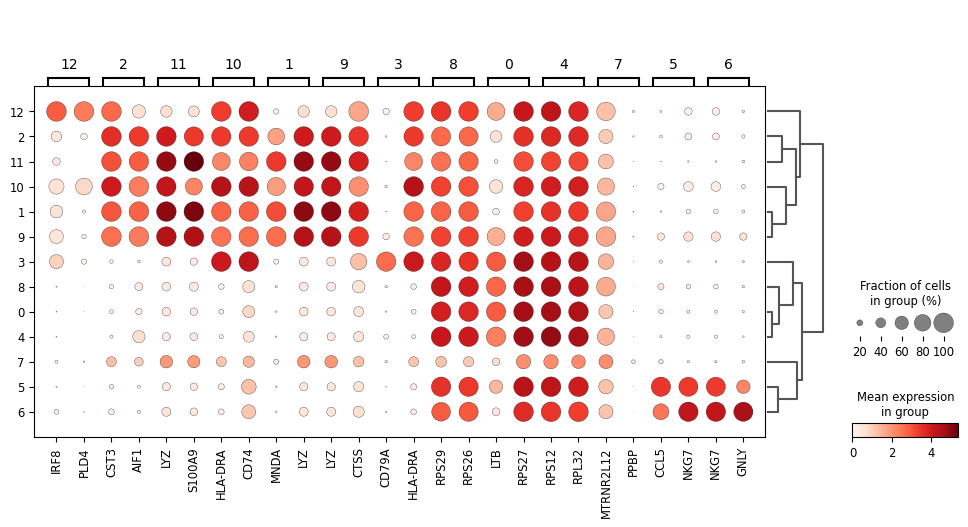

In [59]:
top_markers = []
for x in markers.groupby('group', observed=True ):
    top_markers +=x[1].iloc[0:1].names.tolist()

sc.pl.rank_genes_groups_dotplot(combo, n_genes=2,  groupby="undercluster")


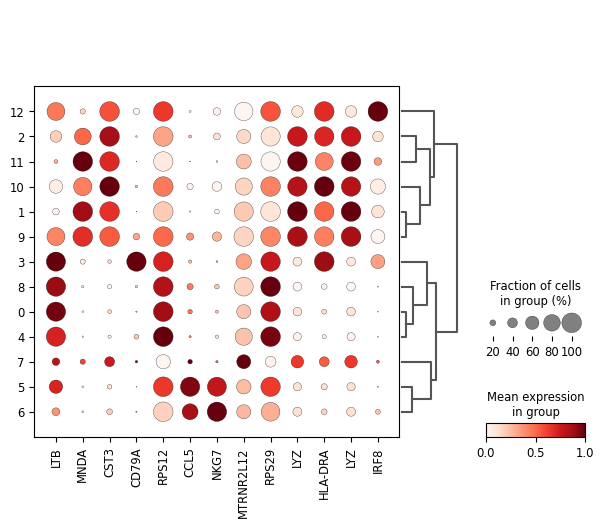

categories: 0, 1, 2, etc.
var_group_labels: T-cell, CD4 T cells, CD14+ Monocytes, etc.


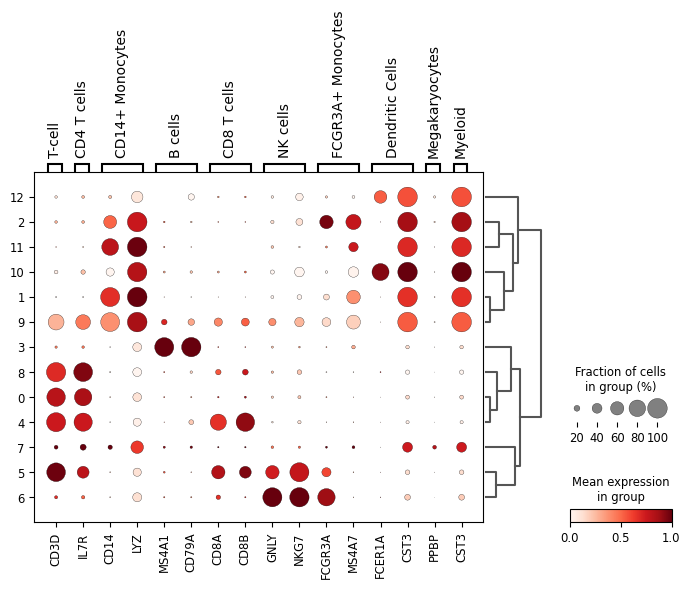

In [60]:
sc.tl.dendrogram(combo, 'undercluster')
sc.pl.dotplot(combo, top_markers , groupby='undercluster', dendrogram=True, mean_only_expressed=True, standard_scale='var')
sc.pl.dotplot(combo, marker_genes, groupby='undercluster', dendrogram=True, mean_only_expressed=True, standard_scale='var')

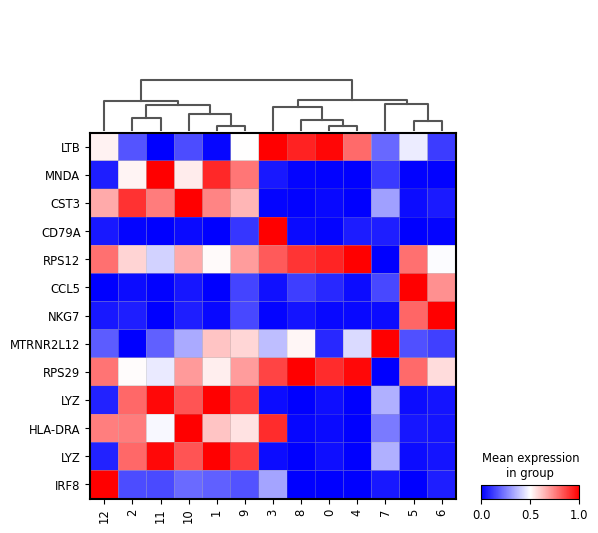

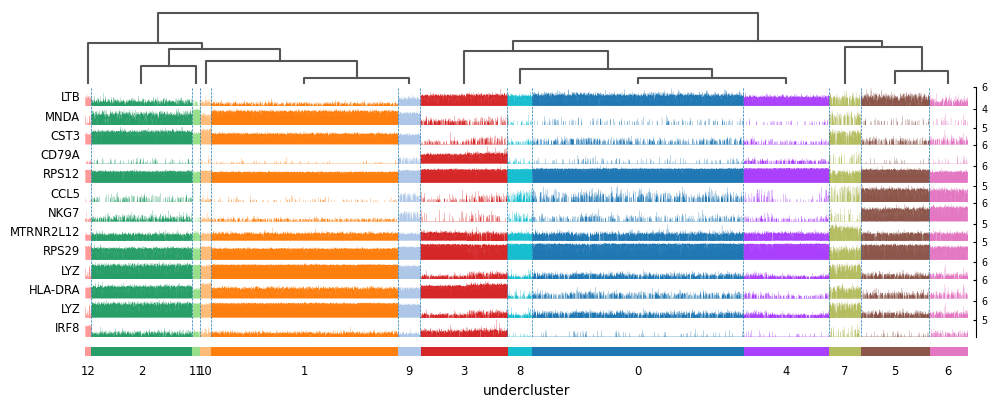

In [61]:
sc.pl.matrixplot(combo, top_markers ,
                 groupby='undercluster',
                 dendrogram=True, standard_scale='var',  cmap='bwr',swap_axes=True,
                )
sc.pl.tracksplot(combo, top_markers, groupby='undercluster', dendrogram=True)


In [39]:
# sc.pl.umap(combo, color=['undercluster']+top_markers, legend_loc='on data')

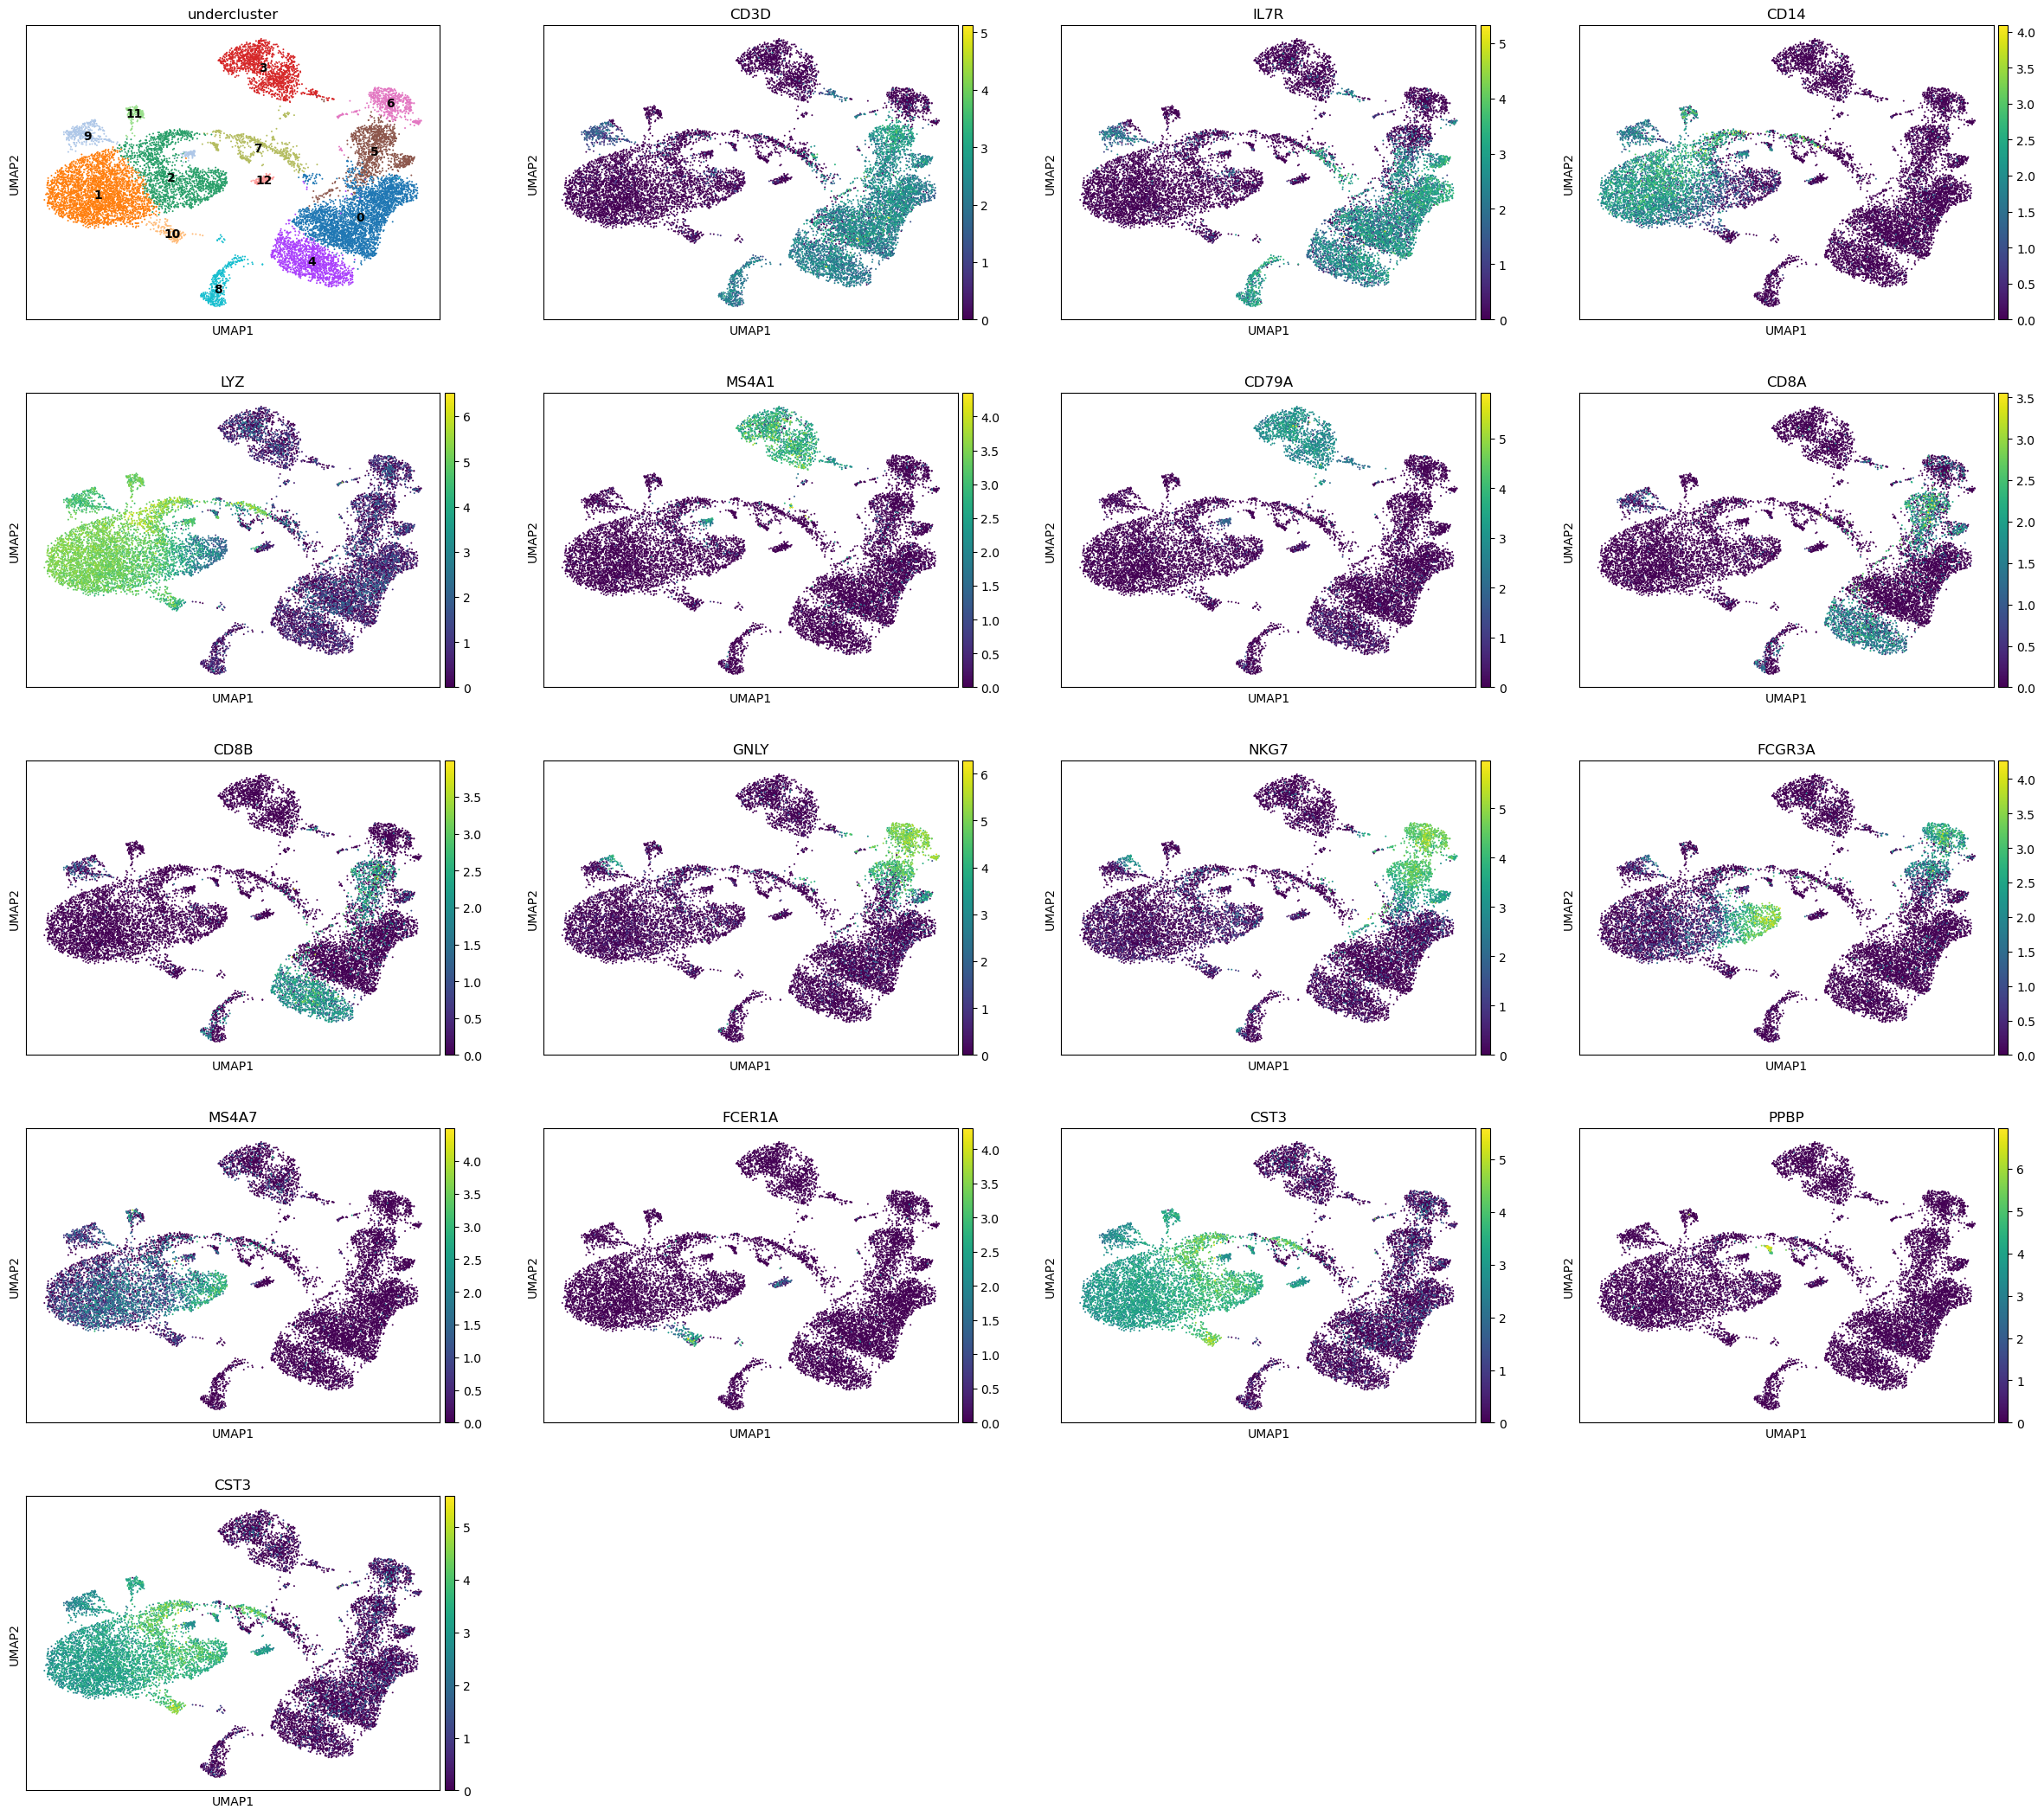

In [62]:
from itertools import chain
sc.pl.umap(combo, color=['undercluster']+list(chain.from_iterable([marker_genes[x] for x in marker_genes])), legend_loc='on data')

In [72]:
combo.obs['cell_type'] = 'unknown'
combo.obs['cell_type'] = combo.obs['cell_type'].astype(str)
combo.obs.loc[pbmc.obs_names,['cell_type']] = pbmc.obs.cell_type.tolist()
combo.obs.loc[pbmc.obs_names]
# pbmc.obs.cell_type

batch undercluster cell_type
AAACATACAACCAC-1  pbmc            5        NK
AAACATTGAGCTAC-1  pbmc            3   B Cells
AAACATTGATCAGC-1  pbmc            0     CD4 T
AAACCGTGCTTCCG-1  pbmc            2    CD14+ 
AAACCGTGTATGCG-1  pbmc            6        NK
...                ...          ...       ...
TTTCGAACTCTCAT-1  pbmc            2    CD14+ 
TTTCTACTGAGGCA-1  pbmc            7   B Cells
TTTCTACTTCCTCG-1  pbmc            3   B Cells
TTTGCATGAGAGGC-1  pbmc            3   B Cells
TTTGCATGCCTCAC-1  pbmc            0   T Cells

[2691 rows x 3 columns]

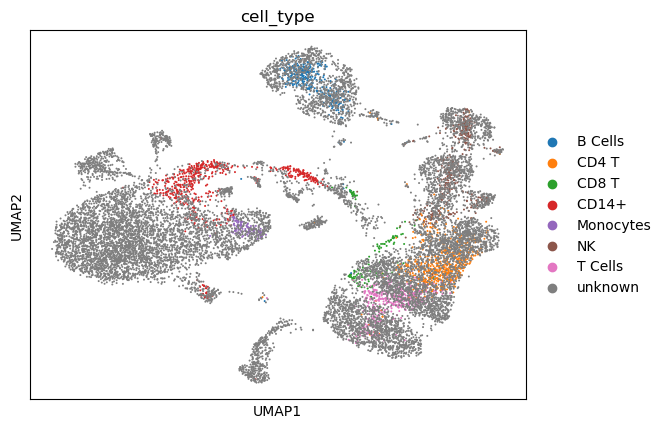

In [73]:
sc.pl.umap(combo, color=['cell_type'])

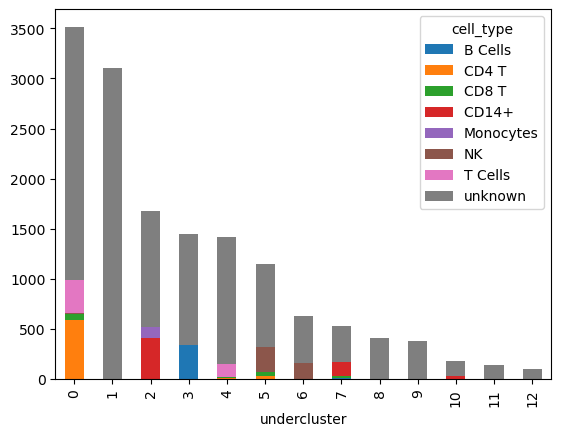

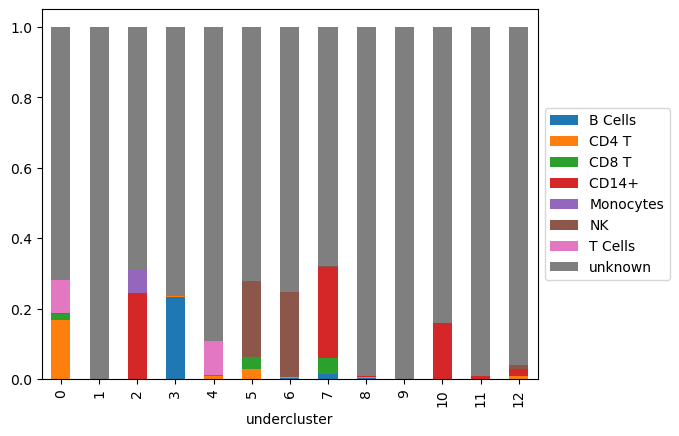

In [74]:
tmp = pd.crosstab(combo.obs.undercluster, combo.obs.cell_type)
pd.crosstab(combo.obs.undercluster, combo.obs.cell_type).plot(kind='bar', stacked=True)
(tmp.T/tmp.sum(1).values).T.plot(kind='bar', stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))